In [1]:
from matplotlib import pyplot as plt
import matplotlib as mpl

import os
import numpy as np
import pandas as pd

from astropy.coordinates import SkyCoord, Angle, Galactic, ICRS
from astropy import units as u
from astropy.table import Table

from shapely.geometry import Polygon

from psycopg2.extras import RealDictCursor
from piaa.utils.postgres import get_db_proxy_conn
from piaa.utils.plot import get_fov_plot

plt.style.use('bmh')

In [2]:
conn = get_db_proxy_conn(db_name='metadata', db_user='panoptes')

### Get Targets by Field

Observational data is stored in a mongodb collection so we aggregate the data here

In [3]:
sequences_sql = f'''
    SELECT t2.unit_id, t1.sequence_id, t1.exp_time, t1.center_ra, t1.center_dec
    FROM images t1, sequences t2
    WHERE t1.sequence_id=t2.id
'''

In [4]:
rows = list()
with conn.cursor(cursor_factory=RealDictCursor) as cursor:
    cursor.execute(sequences_sql)
    rows = cursor.fetchall()
    cursor.close()
    
print(f"Images: {len(rows)}")

Images: 16667


### Build Tables

In [5]:
sequence_table = pd.DataFrame(rows).set_index(['sequence_id']).sort_index().dropna()
sequence_table['num_exp'] = 1

In [6]:
sequence_table.center_ra = pd.to_numeric(sequence_table.center_ra)
sequence_table.center_dec = pd.to_numeric(sequence_table.center_dec)
sequence_table.exp_time = pd.to_numeric(sequence_table.exp_time)

In [7]:
sequence_table.head()

,center_dec,center_ra,exp_time,unit_id,num_exp
sequence_id,,,,,
PAN001_14d3bd_20170417T125400,22.9285,303.9841,100.1,1,1
PAN001_14d3bd_20170417T125400,22.9294,303.9889,100.1,1,1
PAN001_14d3bd_20170417T125400,22.9286,304.0075,100.1,1,1
PAN001_14d3bd_20170417T125400,22.9298,303.9890,100.1,1,1
PAN001_14d3bd_20170417T125400,22.9273,303.9828,100.1,1,1


In [8]:
obs_table = sequence_table.groupby('sequence_id').agg({
    'center_dec': np.mean,
    'center_ra': np.mean,
    'exp_time': np.sum,
    'num_exp': np.sum,
    'unit_id': np.mean, # Ugly
})

In [9]:
# Filter observations w/o a lot of expousres
obs_table = obs_table.loc[obs_table.exp_time > (30 * u.minute).to(u.second)]

In [10]:
# Generate Latex file
stats_table = pd.DataFrame({
    'exp_times': obs_table['exp_time'].sum(level='sequence_id'),
    'num_exp': obs_table['num_exp'].sum(level='sequence_id')
}).sort_values('num_exp')

with open('target_coverage.tex', 'w') as f:
    f.write(stats_table.to_latex())

### Plot

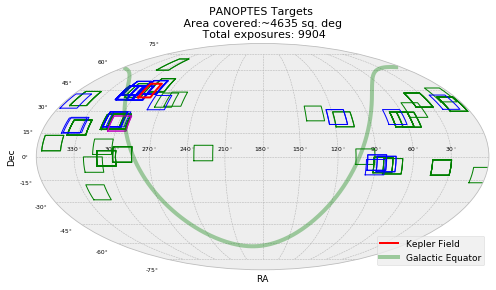

In [11]:
# Polygons for FOV
polys = []

# Offset the Mollweide projection
org = 180 * u.degree


fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(111, projection="mollweide")
ax.tick_params(labelsize=6)


color_lookup = {
    1: 'g',
    6: 'b',
    12: 'm',
}

# FOV for each field
for idx in range(len(obs_table)):
    x, y, poly = get_fov_plot(coords=(obs_table['center_ra'][idx] * u.deg, obs_table['center_dec'][idx] * u.deg), 
                                  org=org, return_polygon=True)    
    polys.append(poly)

#     if idx == 0:
#         ax.plot(x, y, c='blue', lw=1, label=f'PAN{obs_table["unit_id"][idx]:03d} targets')
#     else:
    ax.plot(x, y, c=color_lookup[obs_table['unit_id'][idx]], lw=1)

# Add the Kepler Field
x, y = get_fov_plot(coords=(290.45 * u.degree, 44.4 * u.degree), width=11.5, height=10, org=org)
ax.plot(x, y, c='red', label='Kepler Field')
       
# Show galactic equator - http://balbuceosastropy.blogspot.com.au/2013/09/the-mollweide-projection.html
eq_ra = []
eq_dec = []
for c in Galactic(l=np.arange(120, 475) * u.deg, b=0 * u.deg).transform_to(ICRS):
    x = np.remainder(c.ra + (360 * u.degree) - org, (360 * u.degree)) # shift RA values
    ind = x > (180 * u.degree)
    x[ind] -= (360 * u.degree)    # scale conversion to [-180, 180]
    x=-x                          # reverse the scale: East to the left
    eq_ra.append(Angle(x).radian)
    eq_dec.append(Angle(c.dec).radian)
ax.plot(eq_ra, eq_dec, 'g', lw=4, alpha=0.35, label='Galactic Equator')
    
# Make ticks look nice
tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210]) * u.degree
tick_labels = np.remainder(tick_labels + (360 * u.degree) + org, 360 * u.degree).value
ax.set_xticklabels(["{:.0f}$^\circ$".format(t) for t in tick_labels])

# Get total area
area1 = Polygon()
for p in polys:
    area1 = area1.union(p)

# Legend, labels, title
ax.legend(loc=4, fontsize=9)
ax.set_ylabel('Dec', fontsize=9)
ax.set_xlabel('RA', fontsize=9)    
    
ax.set_title("PANOPTES Targets \n Area covered:" \
             "~{:.0f} sq. deg \n Total exposures: {}".format(
    area1.area, 
    obs_table['num_exp'].sum()), fontsize=11)
fig.tight_layout()

fig.savefig('panoptes_observations_overview.png', dpi=300, transparent=False)

In [12]:
total_time = (obs_table['exp_time'].sum() * u.second)
print("Total exposure time: {:.0f} ({:.02f})".format(total_time, total_time.to(u.hour)))
print("Total num exposures: {}".format(stats_table['num_exp'].sum()))

Total exposure time: 1022471 s (284.02 h)
Total num exposures: 9904
